<a href="https://colab.research.google.com/github/gigihsantoso/prediksi-saham/blob/main/Deep_Learning_Saham_BRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Time Series

##Setup

In [ ]:
import yfinance as yf
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive, files, data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Load Data

In [ ]:
data = yf.download('BRIS.JK', period='max').astype(int).sort_index(ascending=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = data.reset_index()
data['Date']= data['Date'].astype("string")

##Exploring

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1063 non-null   string
 1   Open       1063 non-null   int64 
 2   High       1063 non-null   int64 
 3   Low        1063 non-null   int64 
 4   Close      1063 non-null   int64 
 5   Adj Close  1063 non-null   int64 
 6   Volume     1063 non-null   int64 
dtypes: int64(6), string(1)
memory usage: 58.3 KB


In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-09,600,630,520,545,537,275187300
1,2018-05-11,550,660,550,620,610,285278000
2,2018-05-14,620,650,600,600,591,124691400
3,2018-05-15,600,600,600,600,591,0
4,2018-05-16,600,600,600,600,591,0


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1063.00000,1063.000000,1063.000000,1063.000000,1063.000000,1.063000e+03
mean,1109.38476,1137.390405,1085.067733,1107.113829,1093.267168,5.653874e+07
std,811.73449,837.891488,788.621773,809.700264,800.069744,1.219657e+08
min,136.00000,155.000000,135.000000,135.000000,133.000000,0.000000e+00
25%,505.00000,510.000000,500.000000,505.000000,498.000000,5.353950e+06
50%,605.00000,610.000000,590.000000,600.000000,591.000000,1.282110e+07
75%,1745.00000,1777.500000,1720.000000,1742.500000,1720.500000,4.530785e+07
max,3800.00000,3980.000000,3710.000000,3770.000000,3722.000000,1.318652e+09


##Helper

In [ ]:
def dataframe_split(data, test= 7):
  part_  = data.iloc[:int(test * -1)]
  rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

In [ ]:
def df_to_tsdf(data, input_width, label_width, batch_size):
    series = tf.expand_dims(data, axis=-1)
    fts = tf.data.Dataset.from_tensor_slices(series)
    window = fts.window(input_width+label_width, shift=label_width, drop_remainder=True)
    flat = window.flat_map(lambda w: w.batch(input_width+label_width))
    map = flat.map(lambda w: (w[:input_width * -1], w[label_width * -1:]))
    batch = map.batch(batch_size)
    ds = batch.prefetch(tf.data.AUTOTUNE)
    return ds

##Preprocessing

In [ ]:
df_model = data.copy()
df_model['Scaler'] =  (df_model.loc[:, 'Close']-df_model.loc[:, 'Close'].min())/(df_model.loc[:, 'Close'].max()-df_model.loc[:, 'Close'].min())

In [ ]:
train_m, test_m = dataframe_split(df_model, test=60)

In [ ]:
data_m = train_m['Scaler']
input_width = 30
label_width = 30
batch_size = 128
ds = df_to_tsdf(data_m, input_width, label_width, batch_size)

##Model

In [ ]:
#Buatlah model dengan input layer disarankan menggunakan LSTM LSTM dan output layer 1 
model = tf.keras.models.Sequential([
    #Code Here
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(30),
    # tf.keras.layers.Reshape([6, 1])
])
model.compile(optimizer='SGD', loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(ds, epochs = 3000)

Output streaming akan dipotong hingga 5000 baris terakhir.
1/1 [==============================] - 0s 61ms/step - loss: 0.0575 - mean_absolute_error: 0.1765
Epoch 502/3000
1/1 [==============================] - 0s 44ms/step - loss: 0.0574 - mean_absolute_error: 0.1764
Epoch 503/3000
1/1 [==============================] - 0s 43ms/step - loss: 0.0573 - mean_absolute_error: 0.1764
Epoch 504/3000
1/1 [==============================] - 0s 124ms/step - loss: 0.0573 - mean_absolute_error: 0.1764
Epoch 505/3000
1/1 [==============================] - 0s 131ms/step - loss: 0.0572 - mean_absolute_error: 0.1764
Epoch 506/3000
1/1 [==============================] - 0s 119ms/step - loss: 0.0572 - mean_absolute_error: 0.1764
Epoch 507/3000
1/1 [==============================] - 0s 86ms/step - loss: 0.0571 - mean_absolute_error: 0.1763
Epoch 508/3000
1/1 [==============================] - 0s 57ms/step - loss: 0.0571 - mean_absolute_error: 0.1763
Epoch 509/3000
1/1 [==============================] - 0s 

##Evaluate

In [ ]:
input =tf.convert_to_tensor([test_m['Scaler'].iloc[:-30].to_numpy()])
predictions_m = model.predict(input)

In [ ]:
data_predict = pd.DataFrame(data=test_m['Date'].iloc[-30:], columns=['Date'])
data_predict.insert(1, 'Predict', predictions_m.flatten())
data_predict.set_index('Date', inplace=True)
test_m.set_index('Date', inplace=True)

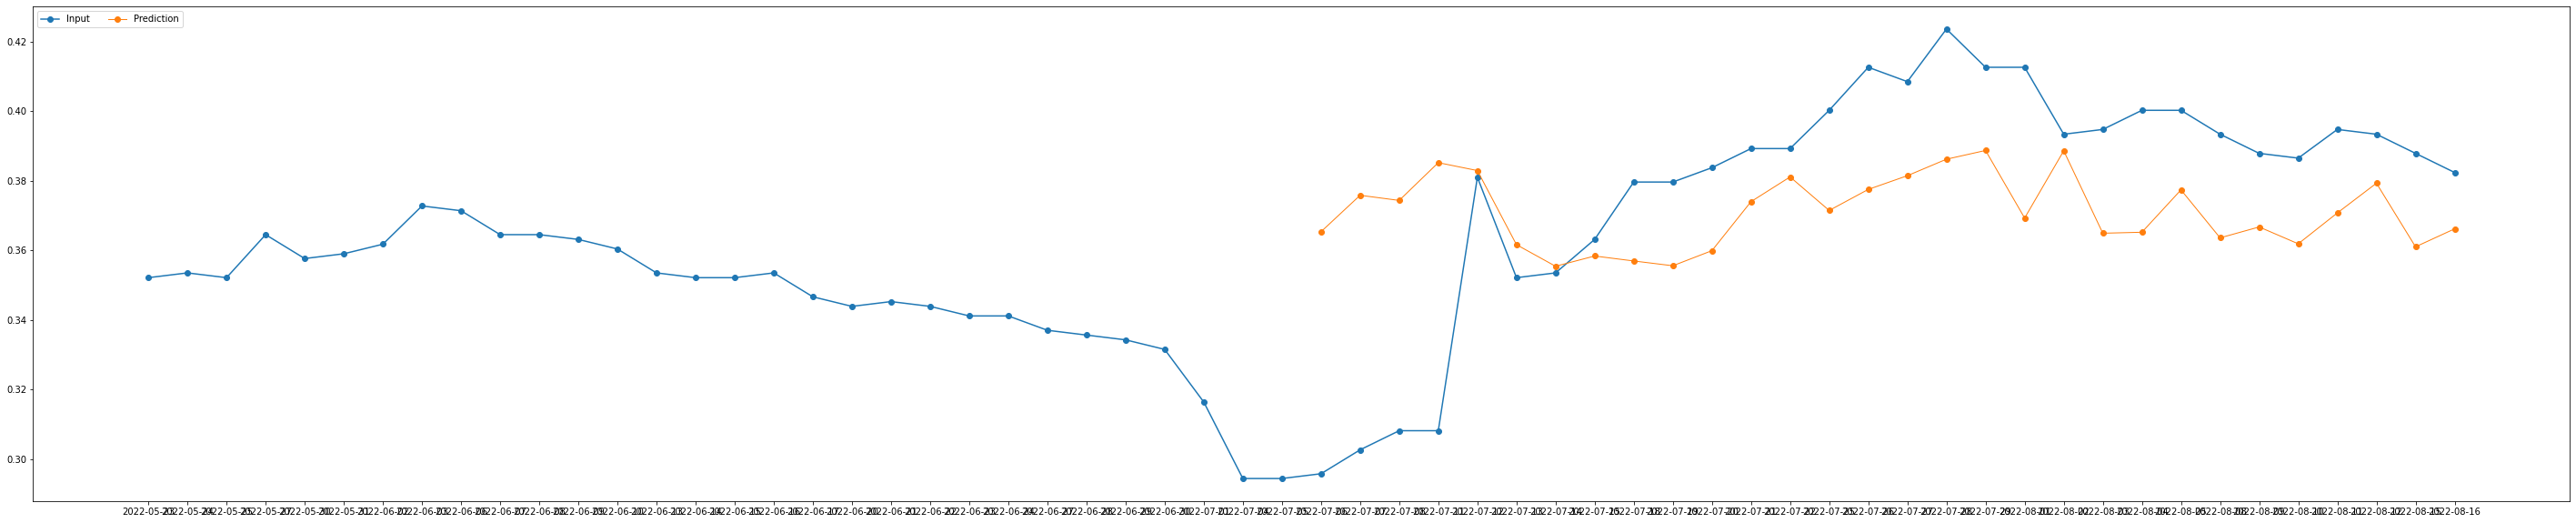

In [ ]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(test_m['Scaler'], marker="o", linewidth=1.5)
ax.plot(data_predict, marker="o", linewidth=1)
ax.legend(["Input", 'Prediction'], loc='upper left', ncol=3, )
plt.show()

##Save Model

In [ ]:
MODEL_DIR = "models/model"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
tf.keras.models.save_model(
    model,
    export_path
)

## Download Save Model

In [ ]:
!zip -r /content/model_bris.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/model/ (stored 0%)
  adding: content/models/model/1/ (stored 0%)
  adding: content/models/model/1/keras_metadata.pb (deflated 88%)
  adding: content/models/model/1/saved_model.pb (deflated 89%)
  adding: content/models/model/1/assets/ (stored 0%)
  adding: content/models/model/1/variables/ (stored 0%)
  adding: content/models/model/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/model/1/variables/variables.index (deflated 52%)


In [ ]:
files.download('/content/model_bris.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>